In [ ]:
#Importing Neccessary Libraries
import numpy as np
import pandas as pd
from pandas import Series
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import plotly.express as px

from plotly.subplots import make_subplots
import plotly.graph_objects as go

#from prophet import Prophet
from pylab import rcParams

from dateutil.parser import parse 
import matplotlib as mpl
import seaborn as sns
#from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})



### OBTAIN

In [2]:
#Reading in the Data
zillow = pd.read_csv('http://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfr_month.csv')
unemp_data = pd.read_excel('https://www.bls.gov/lau/laucnty17.xlsx', skiprows=range(1, 4))
crimes_df = pd.read_csv('/Users/allisondeming/Downloads/IST 718/Assessments/Week 6 Lab/Crimes.csv')

### SCRUB

In [3]:
crimes_df = crimes_df.drop(columns = 'Unnamed: 0')
crimes_df = crimes_df.rename(columns = {'Crime per Population' : 'Crime Rate'})

#clean_crimes.sort_values(by = ['State', 'City'], ascending = [True, True], inplace=True)
#clean_crimes['Crime Rate'] = clean_crimes['Crime Rate'].interpolate(method = 'linear', limit_direction = 'forward')
#clean_crimes['Crime Rate'] = clean_crimes['Crime Rate'].interpolate(method = 'linear', limit_direction = 'backward')

In [4]:
unemp_data = unemp_data.rename(columns = {'Unnamed: 3': 'County/State', 'Unnamed: 9': 'Percent Unemployed'})
unemp_data = unemp_data.drop(unemp_data.index[0:2])

# Make a copy of data frame for scrubbing and cleaning
clean_unemp = unemp_data[['County/State', 'Percent Unemployed']].copy()
clean_unemp[['CountyName','State']] = clean_unemp['County/State'].str.split(',', expand=True)
clean_unemp = clean_unemp.drop(columns = 'County/State')

clean_unemp['State'] = clean_unemp['State'].str.lstrip()
clean_unemp['State'] = clean_unemp['State'].str.rstrip()
clean_unemp[['CountyName', 'State']]= clean_unemp[['CountyName', 'State']].astype(str)
clean_unemp['Percent Unemployed'] = clean_unemp['Percent Unemployed'].astype(float)

#clean_unemp['Percent Unemployed'].dropna()
#clean_unemp.sort_values(by = ['State', 'CountyName'], ascending = [True, True], inplace=True)
#clean_unemp['Percent Unemployed'] = clean_unemp['Percent Unemployed'].interpolate(method = 'linear', limit_direction = 'forward')
#clean_unemp['Percent Unemployed'] = clean_unemp['Percent Unemployed'].interpolate(method = 'linear', limit_direction = 'backward')

clean_unemp[['CountyName', 'State']]= clean_unemp[['CountyName', 'State']].astype(str)
clean_unemp['Percent Unemployed'] = clean_unemp['Percent Unemployed'].astype(float)
                                                                                

In [5]:
zillow[['City', 'State', 'Metro', 'CountyName']] = zillow[['City', 'State', 'Metro', 'CountyName']].astype(str)
zillow[['RegionID', 'RegionName', 'SizeRank']] = zillow[['RegionID', 'RegionName', 'SizeRank']].astype(int)

In [6]:
# Merge housing and clean unemployment data frames
df_merge = pd.merge(zillow, clean_unemp, how = 'left', on = ['CountyName','State'])
df_merge

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,Percent Unemployed
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,2.770188e+06,2.687514e+06,2.663061e+06,2.646544e+06,2.609147e+06,2.778255e+06,2.801284e+06,2.811154e+06,2.909677e+06,4.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,322189.149894,...,8.160084e+05,8.126675e+05,8.253859e+05,8.261098e+05,8.253409e+05,8.365556e+05,8.406963e+05,8.511393e+05,8.586874e+05,5.1
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,5.491636e+06,5.551599e+06,5.242290e+06,5.202065e+06,5.172925e+06,5.169777e+06,5.028796e+06,5.278321e+06,5.040012e+06,4.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,178432.259845,...,4.462612e+05,4.531777e+05,4.601335e+05,4.654635e+05,4.682983e+05,4.781900e+05,4.957764e+05,5.077550e+05,5.252401e+05,5.1
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,435527.325981,...,1.108694e+06,1.104505e+06,1.118697e+06,1.119498e+06,1.115676e+06,1.129559e+06,1.131831e+06,1.146828e+06,1.156474e+06,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29765,78626,34430,47464,Zip,IN,IN,Stinesville,Bloomington,Monroe County,NaN,...,1.739382e+05,1.692898e+05,1.724767e+05,1.692576e+05,1.650589e+05,1.605378e+05,1.551937e+05,1.491120e+05,1.605648e+05,3.6
29766,94014,34430,82938,Zip,WY,WY,McKinnon,Rock Springs,Sweetwater County,NaN,...,2.463179e+05,2.461465e+05,2.476171e+05,2.470421e+05,2.597809e+05,2.629009e+05,2.663056e+05,2.683906e+05,2.676566e+05,4.7
29767,98400,34430,95721,Zip,CA,CA,Twin Bridges,Sacramento--Roseville--Arden-Arcade,El Dorado County,164651.878358,...,4.725199e+05,4.988615e+05,4.867378e+05,4.684227e+05,4.821041e+05,4.972268e+05,4.815580e+05,4.875481e+05,4.683474e+05,4.4
29768,75285,34430,39406,Zip,MS,MS,Hattiesburg,Hattiesburg,Forrest County,NaN,...,2.103643e+05,2.116376e+05,2.121148e+05,2.129546e+05,2.220943e+05,2.226126e+05,2.245492e+05,2.246976e+05,2.261107e+05,5.0


In [7]:
# Merge the Merged and crimes data frame
df_merge = pd.merge(df_merge, crimes_df, how='left', on=['City','State'])
df_merge

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,Percent Unemployed,Population,Total Crimes,Crime Rate
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,2.646544e+06,2.609147e+06,2.778255e+06,2.801284e+06,2.811154e+06,2.909677e+06,4.0,NaN,NaN,NaN
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,322189.149894,...,8.261098e+05,8.253409e+05,8.365556e+05,8.406963e+05,8.511393e+05,8.586874e+05,5.1,NaN,NaN,NaN
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,5.202065e+06,5.172925e+06,5.169777e+06,5.028796e+06,5.278321e+06,5.040012e+06,4.0,NaN,NaN,NaN
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,178432.259845,...,4.654635e+05,4.682983e+05,4.781900e+05,4.957764e+05,5.077550e+05,5.252401e+05,5.1,22797.0,1843.0,8.1
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,435527.325981,...,1.119498e+06,1.115676e+06,1.129559e+06,1.131831e+06,1.146828e+06,1.156474e+06,5.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29765,78626,34430,47464,Zip,IN,IN,Stinesville,Bloomington,Monroe County,NaN,...,1.692576e+05,1.650589e+05,1.605378e+05,1.551937e+05,1.491120e+05,1.605648e+05,3.6,NaN,NaN,NaN
29766,94014,34430,82938,Zip,WY,WY,McKinnon,Rock Springs,Sweetwater County,NaN,...,2.470421e+05,2.597809e+05,2.629009e+05,2.663056e+05,2.683906e+05,2.676566e+05,4.7,NaN,NaN,NaN
29767,98400,34430,95721,Zip,CA,CA,Twin Bridges,Sacramento--Roseville--Arden-Arcade,El Dorado County,164651.878358,...,4.684227e+05,4.821041e+05,4.972268e+05,4.815580e+05,4.875481e+05,4.683474e+05,4.4,NaN,NaN,NaN
29768,75285,34430,39406,Zip,MS,MS,Hattiesburg,Hattiesburg,Forrest County,NaN,...,2.129546e+05,2.220943e+05,2.226126e+05,2.245492e+05,2.246976e+05,2.261107e+05,5.0,45870.0,5072.0,11.1


In [8]:
#df_merge.sort_values(by = ['State', 'City'], ascending = [True, True], inplace=True)
df_merge['Crime Rate'] = df_merge['Crime Rate'].fillna(0)
df_merge = df_merge.loc[(df_merge['Crime Rate'] !=0)]
df_merge
#df_merge['Crime Rate'] = df_merge['Crime Rate'].interpolate(method = 'linear', limit_direction = 'forward')
#df_merge['Crime Rate'] = df_merge['Crime Rate'].interpolate(method = 'linear', limit_direction = 'backward')

#df_merge['Percent Unemployed'] = df_merge['Percent Unemployed'].interpolate(method = 'linear', limit_direction = 'forward')
#df_merge['Percent Unemployed'] = df_merge['Percent Unemployed'].interpolate(method = 'linear', limit_direction = 'backward')

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,Percent Unemployed,Population,Total Crimes,Crime Rate
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,178432.259845,...,465463.540002,468298.263271,478189.967600,495776.383139,507754.991213,525240.072906,5.1,22797.0,1843.0,8.1
5,91940,5,77449,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,100924.057611,...,251740.978805,256351.263981,259873.493825,265513.187529,274128.873344,280256.326307,5.1,22797.0,1843.0,8.1
7,91733,7,77084,Zip,TX,TX,Houston,Houston-The Woodlands-Sugar Land,Harris County,98093.921502,...,254816.061673,258946.787723,262435.138511,267949.953087,276333.539654,281993.800803,5.1,2346155.0,227553.0,9.7
8,93144,8,79936,Zip,TX,TX,El Paso,El Paso,El Paso County,86060.313445,...,184526.182100,186822.299020,188716.762625,191197.154855,194156.670376,200269.168043,4.7,685288.0,26904.0,3.9
12,92593,12,78660,Zip,TX,TX,Pflugerville,Austin-Round Rock,Travis County,154896.622168,...,471861.127417,490956.224377,498063.760509,512030.127222,529686.948694,531942.385441,3.1,67559.0,2531.0,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29745,60401,34322,6701,Zip,CT,CT,Middlebury,New Haven-Milford,New Haven County,NaN,...,372615.784923,392713.245672,374478.637279,349370.096543,340400.915505,345746.727273,4.7,7819.0,142.0,1.8
29751,75924,34322,41101,Zip,KY,KY,Ashland,Huntington-Ashland,Boyd County,63783.593897,...,102038.308642,106139.941945,106435.391595,106978.281856,107685.145456,108166.979177,7.0,19979.0,1365.0,6.8
29755,58952,34322,2872,Zip,RI,RI,Portsmouth,Providence-Warwick,Newport County,120129.577422,...,366335.083592,366064.220002,370298.812200,385265.474716,385955.188525,402395.736842,3.9,17162.0,303.0,1.8
29756,92623,34430,78712,Zip,TX,TX,Austin,Austin-Round Rock,Travis County,NaN,...,123574.365811,126445.799179,127067.103736,126066.625092,132169.967473,130276.885714,3.1,1000276.0,79099.0,7.9


### Functions

In [9]:
# Function to pull the Mean of the Median Housing Prices for entire data set
def preprocess_inputs(df, state, city):
    df = df.copy()
    
    #Take State and City from the dataframe
    df = df[(df.State == state) & ((df.City == city))]
   
    #Use only time series data
    df = df.loc[:, '1996-01-31': '2022-04-30']
    
    #Set Global mean housing price data
    df = pd.DataFrame(df.mean()).reset_index(drop=False)
    
    df = df.rename(columns = { 0:'Mean_Housing', 'index': 'Year-Mon'})
    
    df['Year-Mon'] = pd.to_datetime(df['Year-Mon'])
    
    df = df.set_index('Year-Mon')
    
    return df

In [10]:
# Function to create the Mean of the Median Housing Prices for the train data set
def preprocess_inputs_train(df, state, city):
    df = df.copy()
    
    #Take State and City from the dataframe
    df = df[(df.State == state) & ((df.City == city))]
   
    #Use only time series data
    df = df.loc[:, '1996-01-31': '2017-12-31']
    
    #Set Global mean housing price data
    df = pd.DataFrame(df.mean()).reset_index(drop=False)
    
    df = df.rename(columns = { 0:'Mean_Housing', 'index': 'Year-Mon'})
    
    df['Year-Mon'] = pd.to_datetime(df['Year-Mon'])
    
    df = df.set_index('Year-Mon')
    
    return df


In [11]:
# Function to create the Mean of the Median Housing Prices for the test data set
def preprocess_inputs_test(df, state, city):
    df = df.copy()
    
    #Take State and City from the dataframe
    df = df[(df.State == state) & ((df.City == city))]
   
    #Use only time series data
    df = df.loc[:, '2018-01-31': '2018-12-31']
    
    #Set Global mean housing price data
    df = pd.DataFrame(df.mean()).reset_index(drop=False)
    
    df = df.rename(columns = { 0:'Mean_Housing', 'index': 'Year-Mon'})
    
    df['Year-Mon'] = pd.to_datetime(df['Year-Mon'])
    
    df = df.set_index('Year-Mon')
    
    return df

In [12]:
# Function to perform the graph and test the stationary of the train data set
def stationary_test(dataset):
    
    #Rolling statistics
    rolmean = dataset.rolling(window=12).mean()
    rolstd = dataset.rolling(window=12).std()
    
    #Plotting 
    plt.plot(dataset, color = 'blue', label = 'Raw Data')
    plt.plot(rolmean, color = 'red', label = 'Mean of Median Housing Price')
    plt.plot(rolstd, color = 'green', label = 'Std of Meadian Hosing Price')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Dickey-Fuller Test
    data_adftest = adfuller(dataset['Mean_Housing'], autolag = 'AIC')

    data_adfoutput = pd.Series(data_adftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, values in data_adftest[4].items():
        data_adfoutput['Critical Values (%s)'%key] = values

    print('Dickey-Fuller Test:')
    print(data_adfoutput)

### EXPLORE

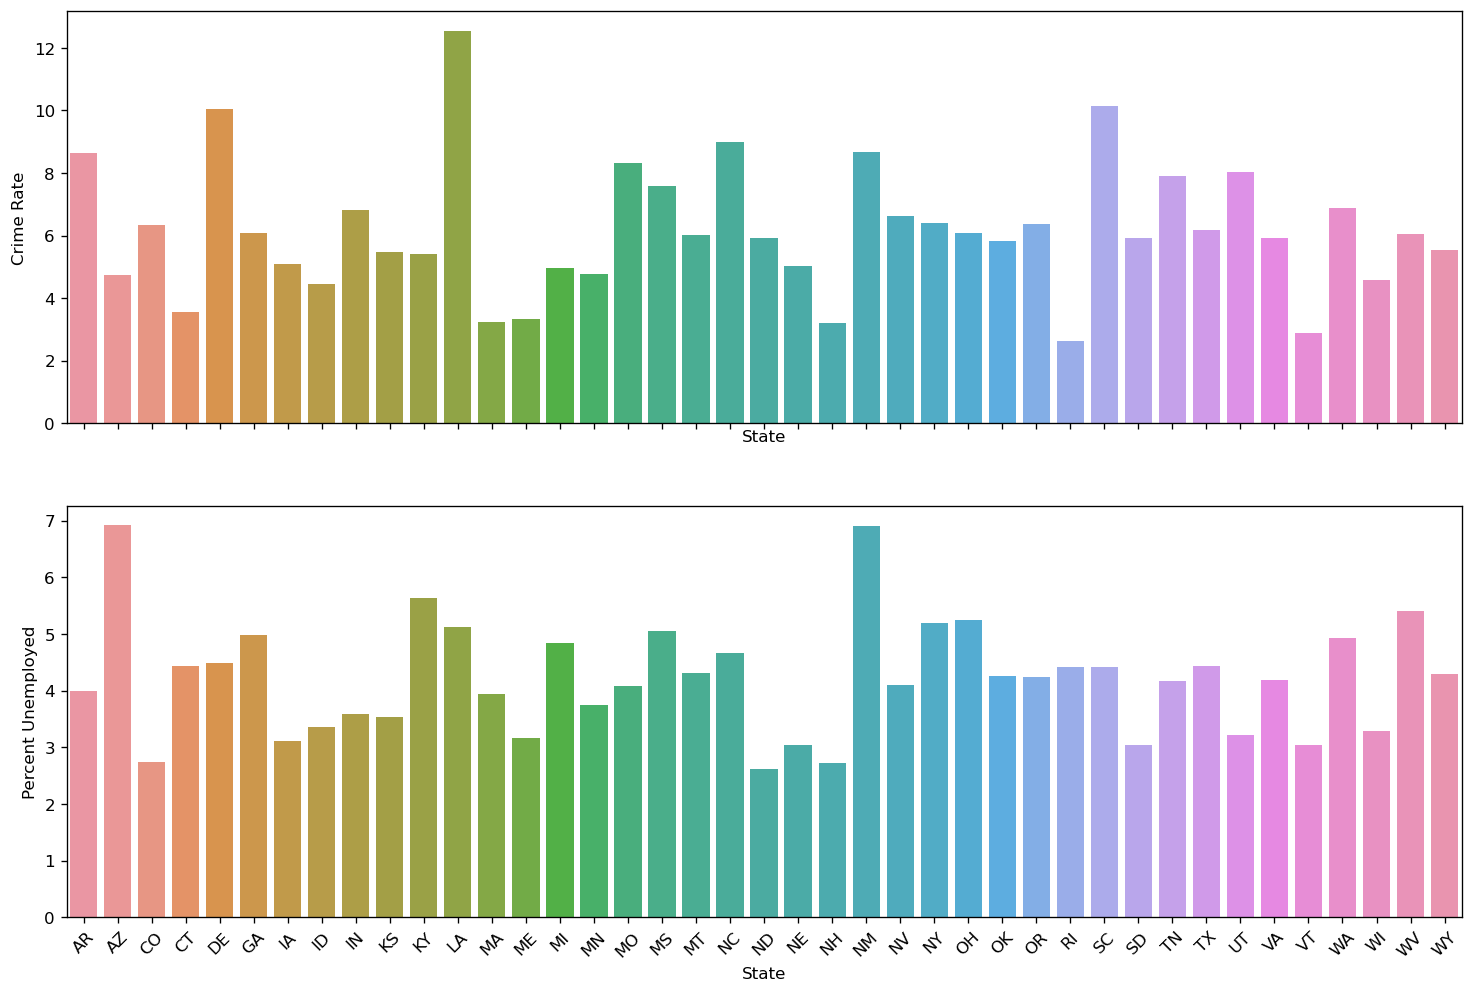

The state with lowest Unemployment Percent
   State  Percent Unemployed
20    ND            2.621053 

The state with the lowest Crime Rate
   State  Crime Rate
12    MA    3.245708
13    ME    3.343478
22    NH    3.195135
29    RI    2.611940
36    VT    2.871930


In [13]:
crime_analysis = df_merge.groupby('State')[['Crime Rate']].mean()
crime_analysis.reset_index(inplace=True)

unemp_analysis = df_merge.groupby('State')[['Percent Unemployed']].mean()
unemp_analysis.reset_index(inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex = True)
sns.barplot(x ='State', y = 'Crime Rate', data=crime_analysis, ax=ax[0])
sns.barplot(x ='State', y = 'Percent Unemployed', data=unemp_analysis, ax=ax[1])
plt.xticks(rotation=45)
plt.show(block=False)

print('The state with lowest Unemployment Percent')
lowest_unemp_state = unemp_analysis.loc[(unemp_analysis['Percent Unemployed'] == unemp_analysis['Percent Unemployed'].min())]
print(lowest_unemp_state,'\n')

print('The state with the lowest Crime Rate')      
lowest_crime_state = crime_analysis.loc[(crime_analysis['Crime Rate'] <= 3.5)]
print(lowest_crime_state)

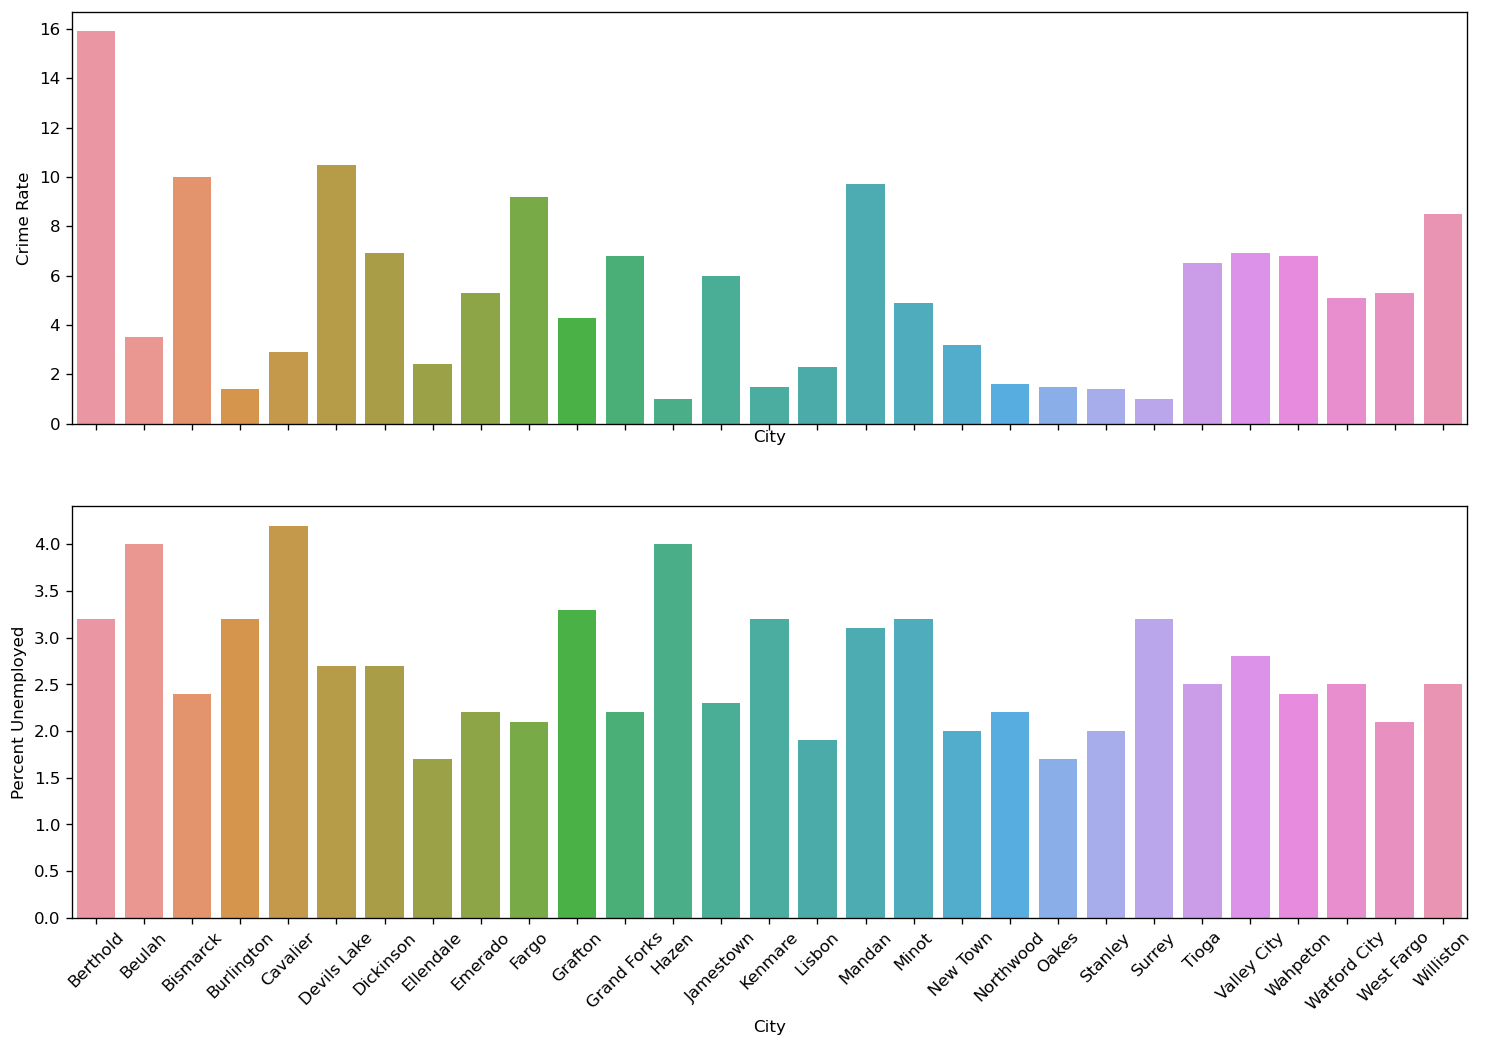

The cities with Unemployment Percent less than 3.0%
            City  Percent Unemployed
2       Bismarck                 2.4
5    Devils Lake                 2.7
6      Dickinson                 2.7
7      Ellendale                 1.7
8        Emerado                 2.2
9          Fargo                 2.1
11   Grand Forks                 2.2
13     Jamestown                 2.3
15        Lisbon                 1.9
18      New Town                 2.0
19     Northwood                 2.2
20         Oakes                 1.7
21       Stanley                 2.0
23         Tioga                 2.5
24   Valley City                 2.8
25      Wahpeton                 2.4
26  Watford City                 2.5
27    West Fargo                 2.1
28     Williston                 2.5 



In [14]:
# City in ND with the lowest Percent Unemployed
df_ND = df_merge.loc[(df_merge['State'] == 'ND')]

crime_analysis_ND = df_ND.groupby('City')[['Crime Rate']].mean()
crime_analysis_ND.reset_index(inplace=True)

unemp_analysis_ND = df_ND.groupby('City')[['Percent Unemployed']].mean()
unemp_analysis_ND.reset_index(inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex = True)
sns.barplot(x ='City', y = 'Crime Rate', data=crime_analysis_ND, ax=ax[0])
sns.barplot(x ='City', y = 'Percent Unemployed', data=unemp_analysis_ND, ax=ax[1])
plt.xticks(rotation=45)
plt.show(block=False)

print('The cities with Unemployment Percent less than 3.0%')
lowest_unemp_state = unemp_analysis_ND.loc[(unemp_analysis_ND['Percent Unemployed'] < 3.0)]
print(lowest_unemp_state,'\n')


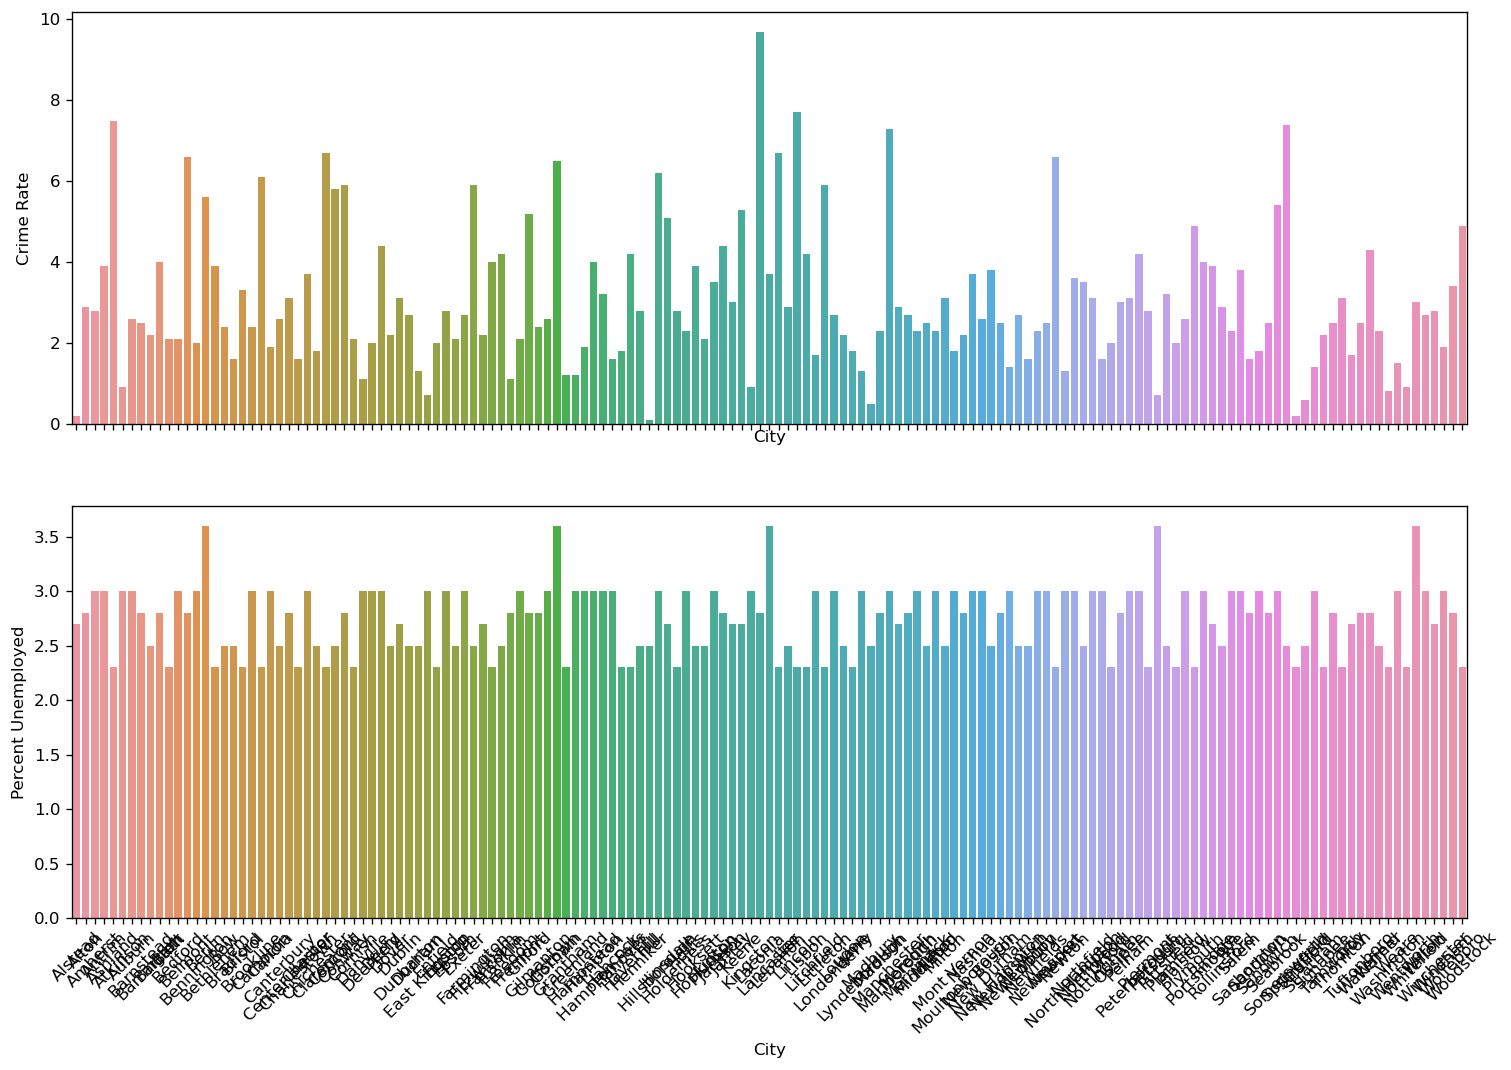

The cities with Crime Rate less than 1%:
              City  Crime Rate
0          Alstead         0.2
5         Atkinson         0.9
38   East Kingston         0.7
62            Hill         0.1
73        Kingston         0.9
86         Madbury         0.5
117      Pittsburg         0.7
132    Springfield         0.2
133      Strafford         0.6
142     Washington         0.8
144      Wentworth         0.9 



In [15]:
# City in RI with the lowest Crime Rate
df_NH = df_merge.loc[(df_merge['State'] == 'NH')]

crime_analysis_NH = df_NH.groupby('City')[['Crime Rate']].mean()
crime_analysis_NH.reset_index(inplace=True)

unemp_analysis_NH = df_NH.groupby('City')[['Percent Unemployed']].mean()
unemp_analysis_NH.reset_index(inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex = True)
sns.barplot(x ='City', y = 'Crime Rate', data=crime_analysis_NH, ax=ax[0])
sns.barplot(x ='City', y = 'Percent Unemployed', data=unemp_analysis_NH, ax=ax[1])
plt.xticks(rotation=45)
plt.show(block=False)

print('The cities with Crime Rate less than 1%:')
lowest_crime_state = crime_analysis_NH.loc[(crime_analysis_NH['Crime Rate'] < 1.0)]
print(lowest_crime_state,'\n')

In [16]:
zillow_clean =  df_merge.loc[:, 'State':'2017-12-31']
zillow_clean = zillow_clean.drop(columns = ['City', 'Metro', 'CountyName'])
zillow_clean = zillow_clean.groupby('State').mean()
zillow_clean = zillow_clean.transpose()
#zillow_clean = zillow_clean.mean()
zillow_clean

State,AR,AZ,CO,CT,DE,GA,IA,ID,IN,KS,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
1996-01-31,68638.167865,114666.472051,164454.342184,175692.380642,127410.688182,100717.758846,103103.253131,100010.680885,75899.388112,NaN,...,NaN,80440.589378,143379.781715,187981.772167,131627.840657,125299.153401,173367.235800,116866.939903,72964.895077,NaN
1996-02-29,68550.059639,114956.767584,165528.804223,174074.353454,126549.023407,101063.715001,103409.839140,99300.153599,83201.942635,NaN,...,NaN,80517.113764,142534.624789,188066.716604,130098.171691,125025.700354,173132.224458,116915.378420,73349.631531,NaN
1996-03-31,68837.676315,115570.938085,166393.181069,174273.199732,126403.119890,101654.922285,104081.458009,99274.429800,82668.782568,NaN,...,NaN,80987.671623,142519.682865,188978.590089,130316.153493,125071.667509,173473.283269,115140.308589,73682.615226,NaN
1996-04-30,68798.947050,115618.887103,167520.659851,174648.283273,125858.107777,102111.885893,103906.211832,99448.087582,84194.165817,NaN,...,NaN,81462.729624,142897.704559,189084.706832,130194.845539,124818.462823,173779.342243,114905.673366,73822.354326,NaN
1996-05-31,68979.711440,116419.919841,169049.730631,174911.679733,127566.061802,102601.676918,104442.926479,99546.494628,80795.974094,NaN,...,NaN,82017.368991,143368.697154,192807.131285,130217.401316,125184.232105,172083.993402,115888.188104,73831.918079,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,117773.163805,233115.866089,472236.995869,382988.366109,276491.330296,189283.230242,161520.872238,279808.855156,156275.466269,188361.341136,...,204122.613316,157580.405260,224820.514072,341591.873867,241705.405855,276960.014327,430663.166962,190822.748384,109518.836937,190696.896279
2017-09-30,117954.930661,235168.720298,474420.115668,381064.586485,276515.071758,190794.227691,161643.938882,281135.163940,156250.837668,189114.067698,...,204835.552269,158356.132400,225262.490298,343090.683088,243309.070307,277958.885576,432256.101425,190486.931580,109939.308649,191247.670755
2017-10-31,118194.444413,237015.105783,476776.583933,381978.553954,277759.208882,191898.620020,162195.111945,282446.987043,157203.495415,189797.306543,...,204534.008689,159210.441785,226136.463668,344457.516969,243197.874487,277885.658469,437607.526161,191022.616432,109691.353605,192145.366034
2017-11-30,118905.532499,237492.250252,479298.129023,384067.290649,278955.621417,192856.237377,162576.704881,285031.216061,157823.438700,189605.250959,...,205411.240635,160476.511011,227529.502823,346678.306006,243230.112415,278511.000053,438269.801492,191842.832783,110298.234822,193053.799995


<AxesSubplot:>

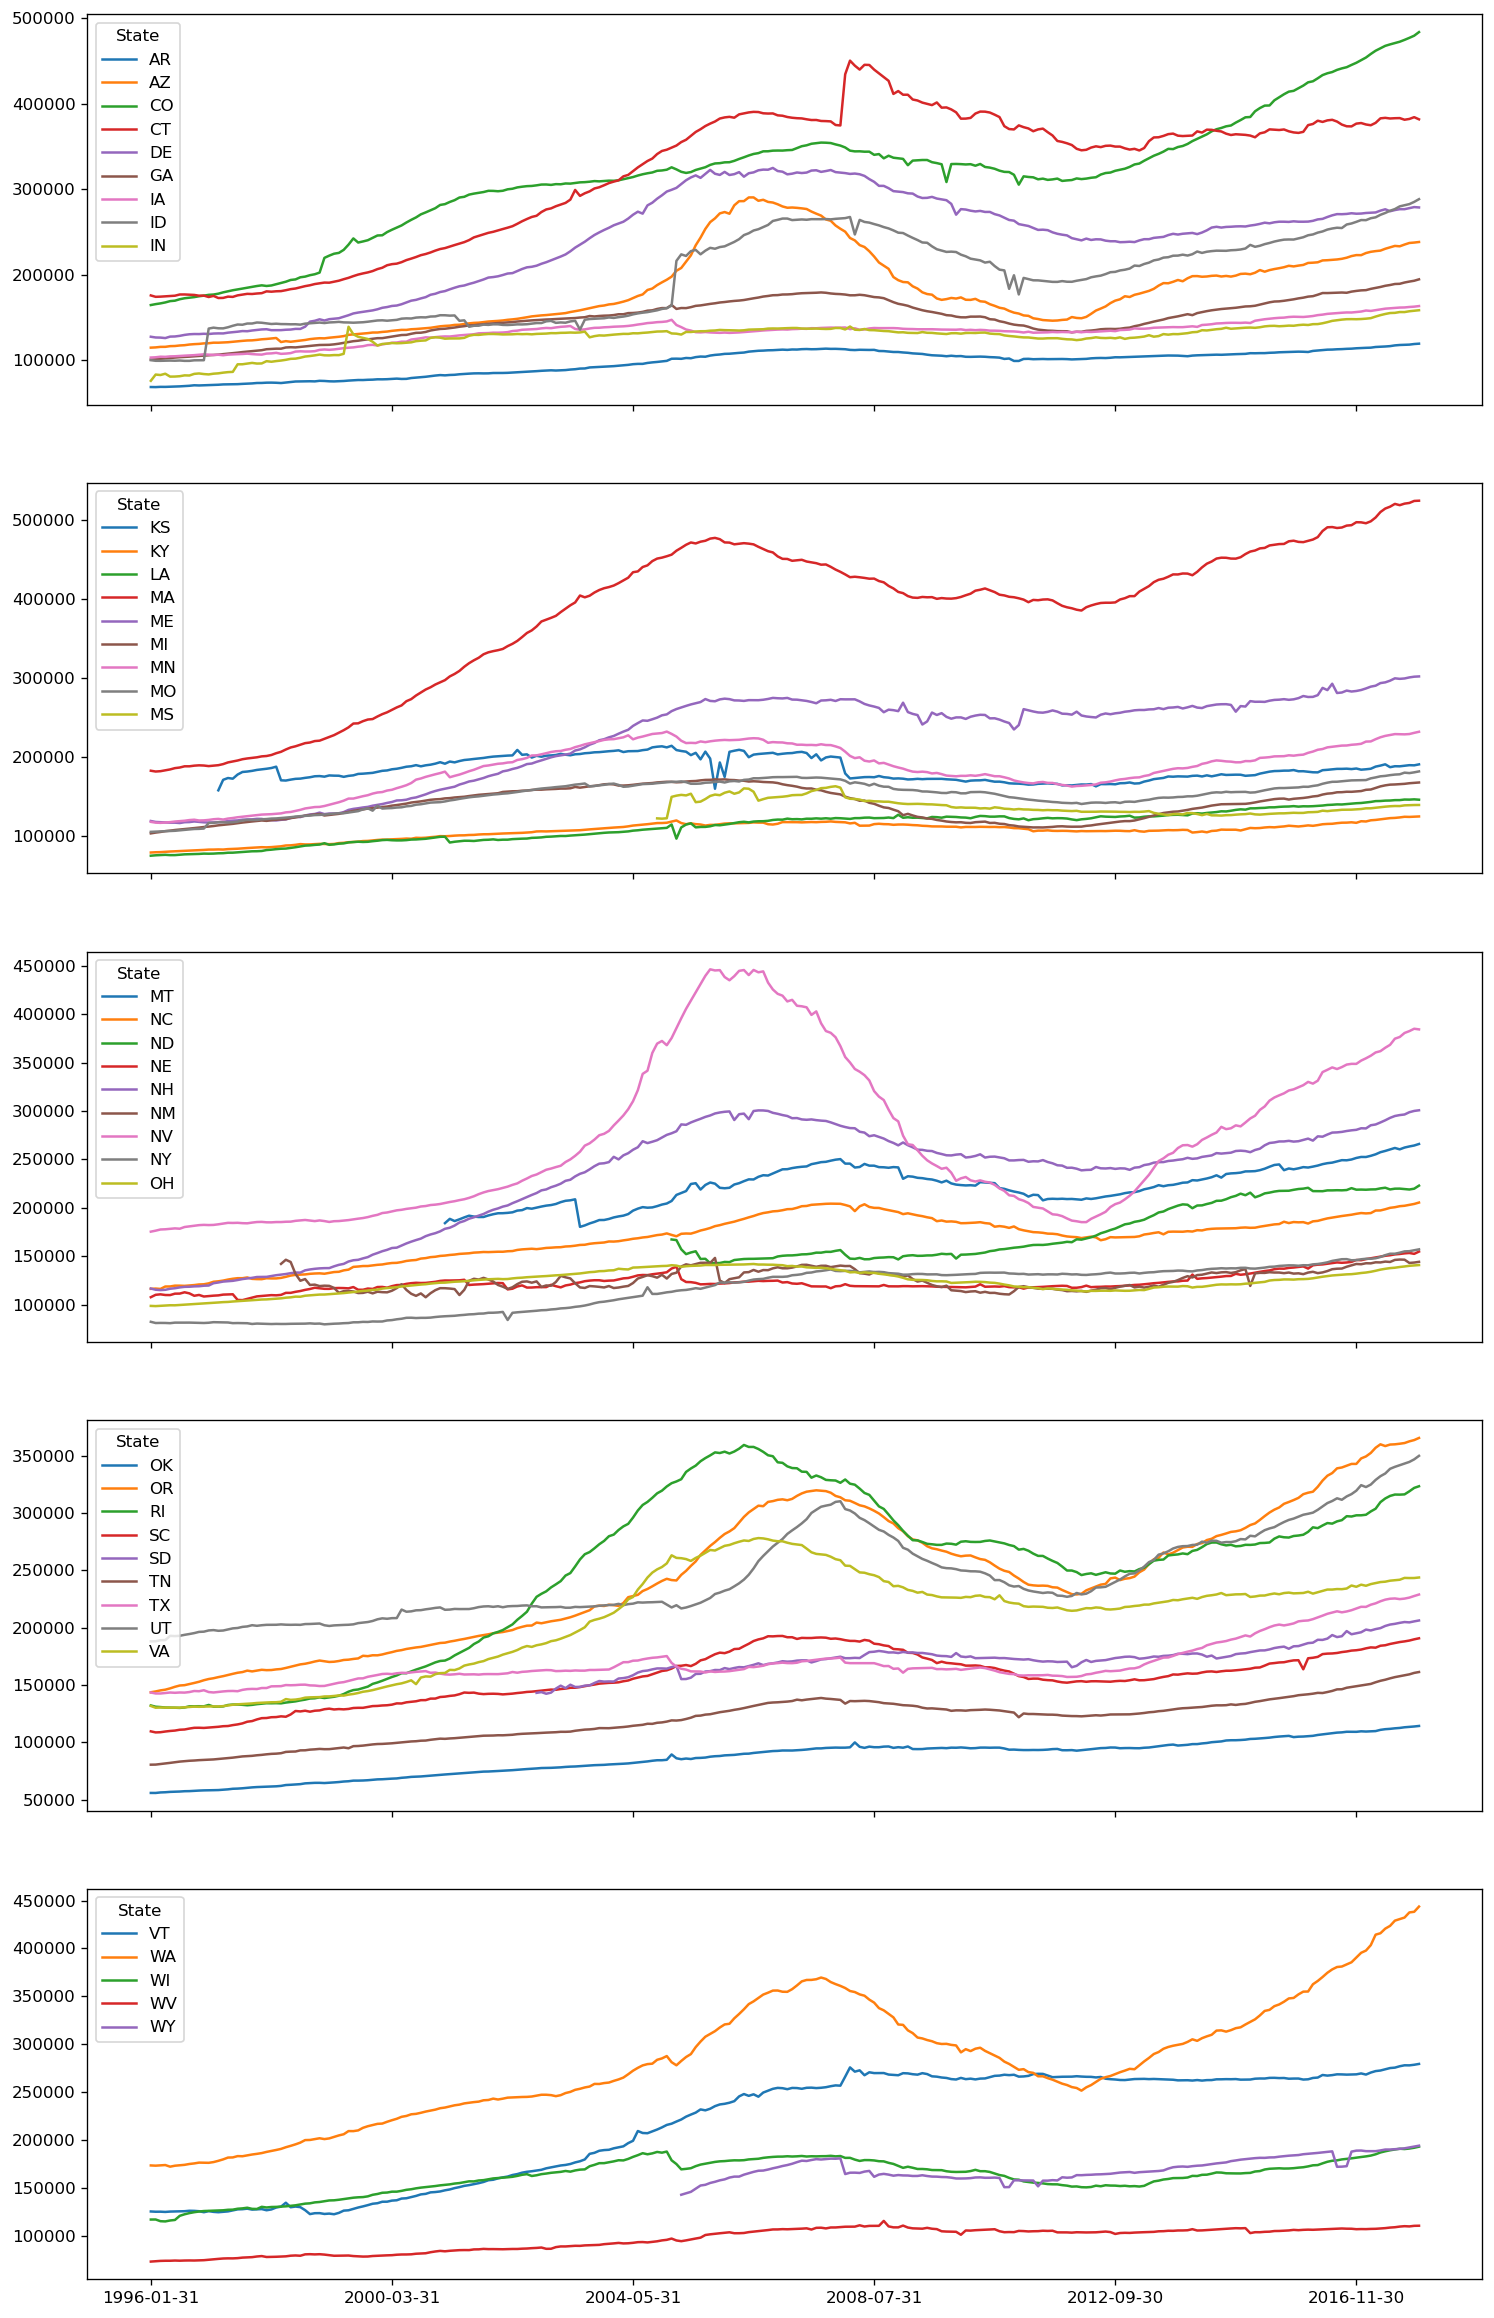

In [17]:
zillow_analysis1 = zillow_clean.loc[:,'AR':'IN']
zillow_analysis2 = zillow_clean.loc[:,'KS':'MS']
zillow_analysis3 = zillow_clean.loc[:, 'MT':'OH']
zillow_analysis4 = zillow_clean.loc[:, 'OK':'VA']
zillow_analysis5 = zillow_clean.loc[:, 'VT':'WY']
fig, ax = plt.subplots(5, 1, figsize=(15,25), sharex = True)
zillow_analysis1.plot(ax=ax[0])
zillow_analysis2.plot(ax=ax[1])
zillow_analysis3.plot(ax=ax[2])
zillow_analysis4.plot(ax=ax[3])
zillow_analysis5.plot(ax=ax[4])

In [18]:
zillow_clean2 = df_merge.loc[(df_merge['State']== 'CO')]
zillow_clean2= zillow_clean2.groupby('City').agg(np.mean)
zillow_clean2 = zillow_clean2.drop(['RegionID', 'SizeRank', 'Percent Unemployed', 'Population', 'Total Crimes', 'Crime Rate'], axis=1)
zillow_clean2 = zillow_clean2.transpose()
zillow_clean2 = pd.DataFrame(zillow_clean2.mean(axis=0))
zillow_clean2[0] = zillow_clean2[0].astype(int)
#zillow_highest_city_mean = zillow_clean2.sort_values(by =0,ascending=False)
zillow_highest_city_mean = zillow_clean2.loc[(zillow_clean2[0] == zillow_clean2[0].max())]
print('The city with the highest meean housing price in Colorado:')
print(zillow_highest_city_mean)

The city with the highest meean housing price in Colorado:
                        0
City                     
Snowmass Village  2819728


### QUESTION ONE

In [19]:
fay = preprocess_inputs(df_merge, 'AR', 'Fayetteville')
little = preprocess_inputs(df_merge, 'AR', 'Little Rock')
hot = preprocess_inputs(df_merge, 'AR', 'Hot Springs')
searcy  = preprocess_inputs(df_merge, 'AR', 'Searcy')

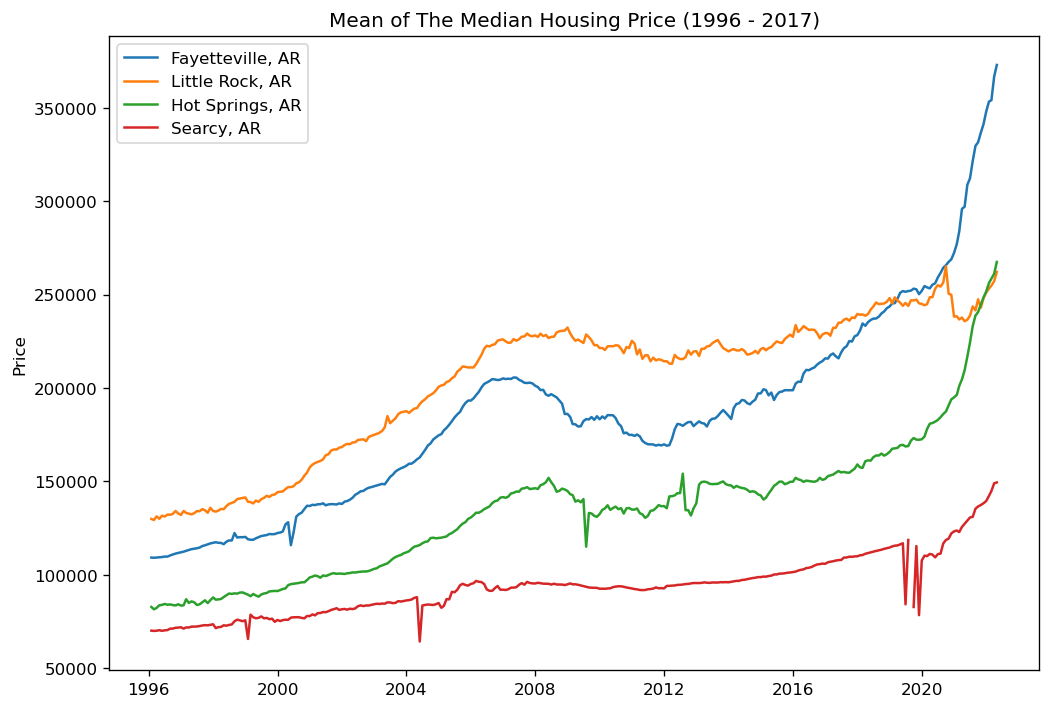

In [20]:
plt.plot(fay, label = 'Fayetteville, AR' )
plt.plot(little, label = 'Little Rock, AR')
plt.plot(hot, label = 'Hot Springs, AR')
plt.plot(searcy, label = 'Searcy, AR')
plt.ylabel('Price')
plt.title('Mean of The Median Housing Price (1996 - 2017)')
plt.legend(loc='best')
plt.show(block=False)

### MODEL

### QUESTION 2

### Historically has the highest Mean for the Meadian Housing Price:  TEST & TRAIN

In [21]:
snowmass_train = preprocess_inputs_train(df_merge, 'CO', 'Snowmass Village').dropna()

In [22]:
snowmass_test = preprocess_inputs_test(df_merge, 'CO', 'Snowmass Village').dropna()

### State and city with lowest Crime Rate:  TEST & TRAIN

In [23]:
east_train = preprocess_inputs_train(df_merge, 'NH', 'East Kingston').dropna()

In [24]:
east_test = preprocess_inputs_test(df_merge, 'NH', 'East Kingston').dropna()

### State and city with best unemployment:  TEST & TRAIN

In [25]:
dlake_train = preprocess_inputs_train(df_merge, 'ND', 'Devils Lake').dropna()

In [26]:
dlake_test = preprocess_inputs_test(df_merge, 'ND', 'Devils Lake').dropna()

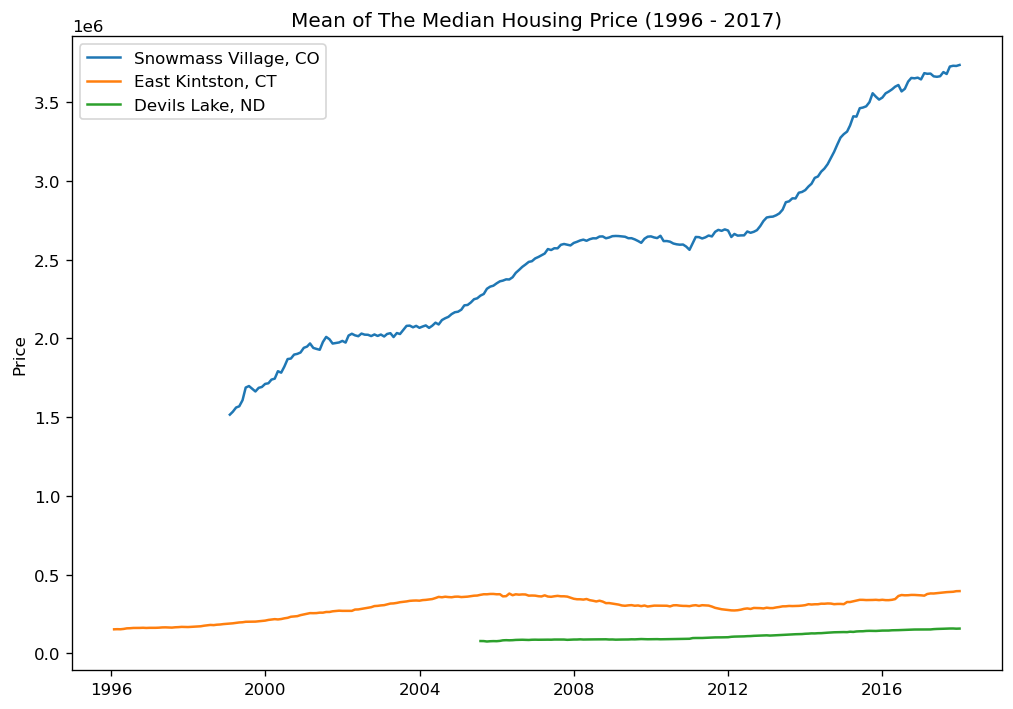

In [27]:
plt.plot(snowmass_train, label = 'Snowmass Village, CO' )
plt.plot(east_train, label = 'East Kintston, CT')
plt.plot(dlake_train, label = 'Devils Lake, ND')
plt.ylabel('Price')
plt.title('Mean of The Median Housing Price (1996 - 2017)')
plt.legend(loc='best')
plt.show(block=False)

### Creating the train (1996-2017) and test set (2018)

In [28]:
#train = dlake_train
#test = dlake_test
train = snowmass_train
test = snowmass_test
#train = east_train
#test = east_test

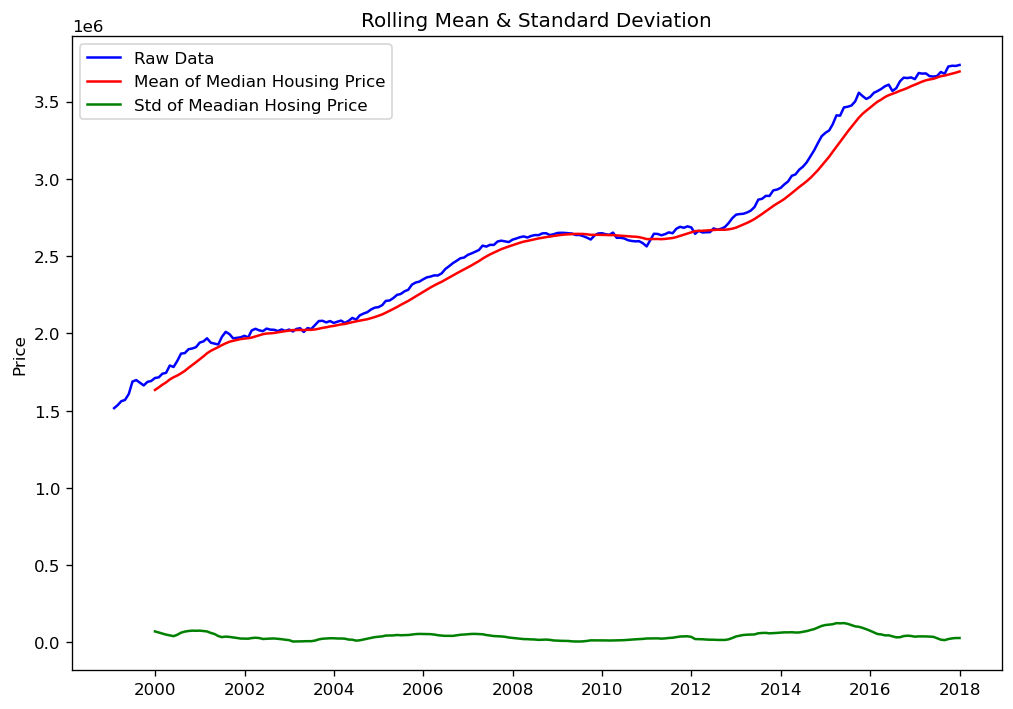

Dickey-Fuller Test:
Test Statistic                  -0.065392
p-value                          0.952778
#Lags Used                      12.000000
Number of Observations Used    214.000000
Critical Values (1%)            -3.461282
Critical Values (5%)            -2.875143
Critical Values (10%)           -2.574020
dtype: float64


In [29]:
stationary_test(train)

### Transformation using Log Scale

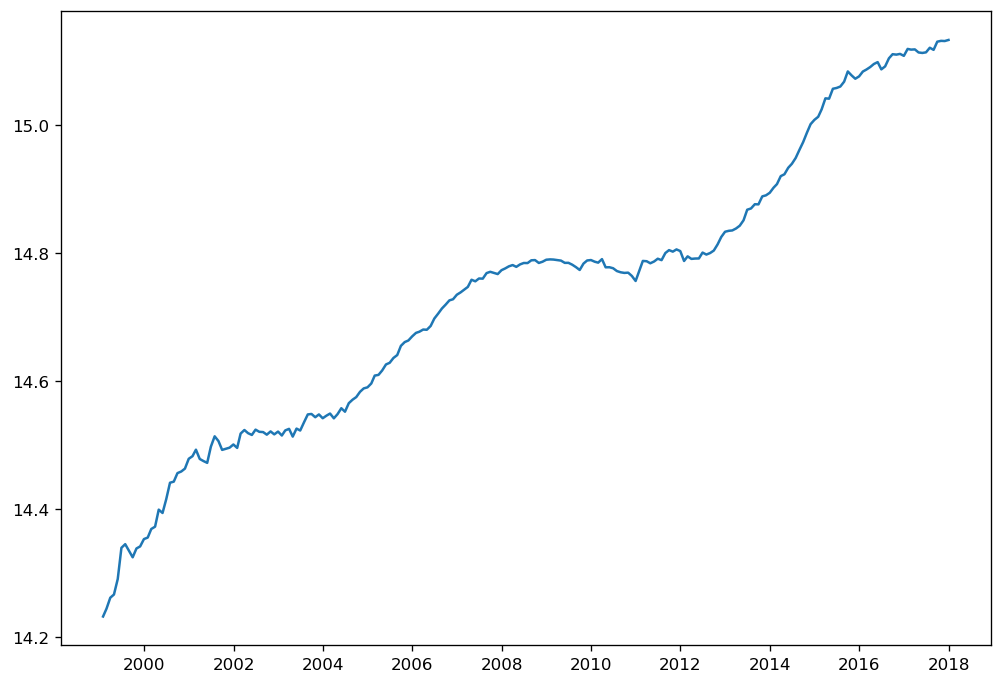

In [30]:
# Transformation of data using Log
df_logscale = np.log(train)
plt.plot(df_logscale)
plt.show(block=False)

In [31]:
mul_result = seasonal_decompose(df_logscale, model='multiplicative')
mul_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)
plt.show(block=False)

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

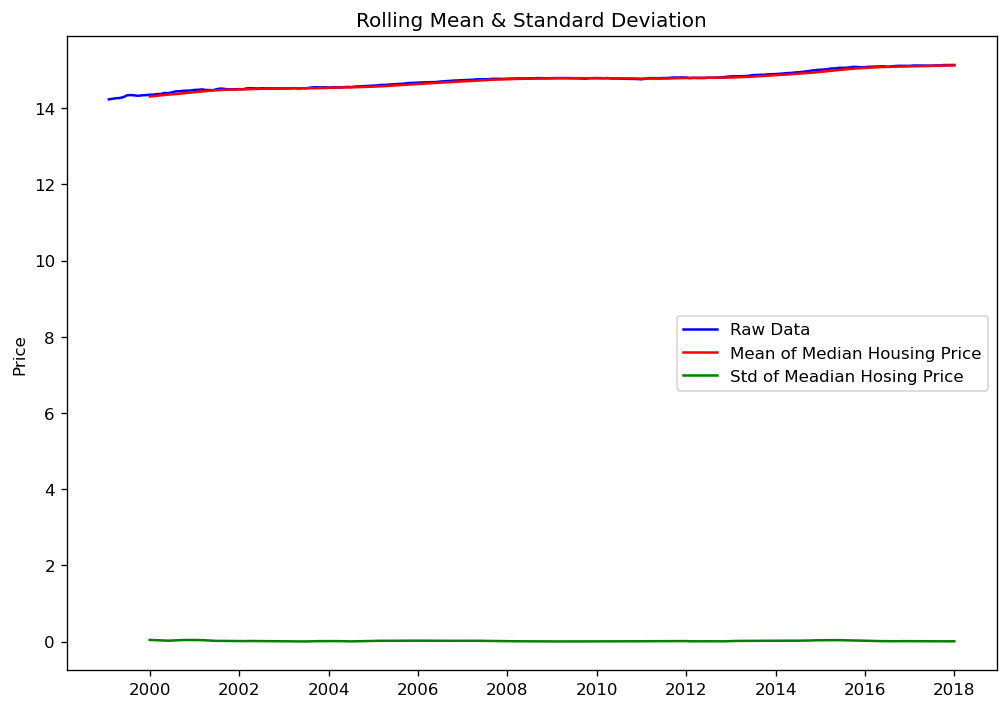

Dickey-Fuller Test:
Test Statistic                  -0.682002
p-value                          0.851357
#Lags Used                      12.000000
Number of Observations Used    214.000000
Critical Values (1%)            -3.461282
Critical Values (5%)            -2.875143
Critical Values (10%)           -2.574020
dtype: float64


In [32]:
stationary_test(df_logscale)

### Differencing the data by Log -  Log Moving Average

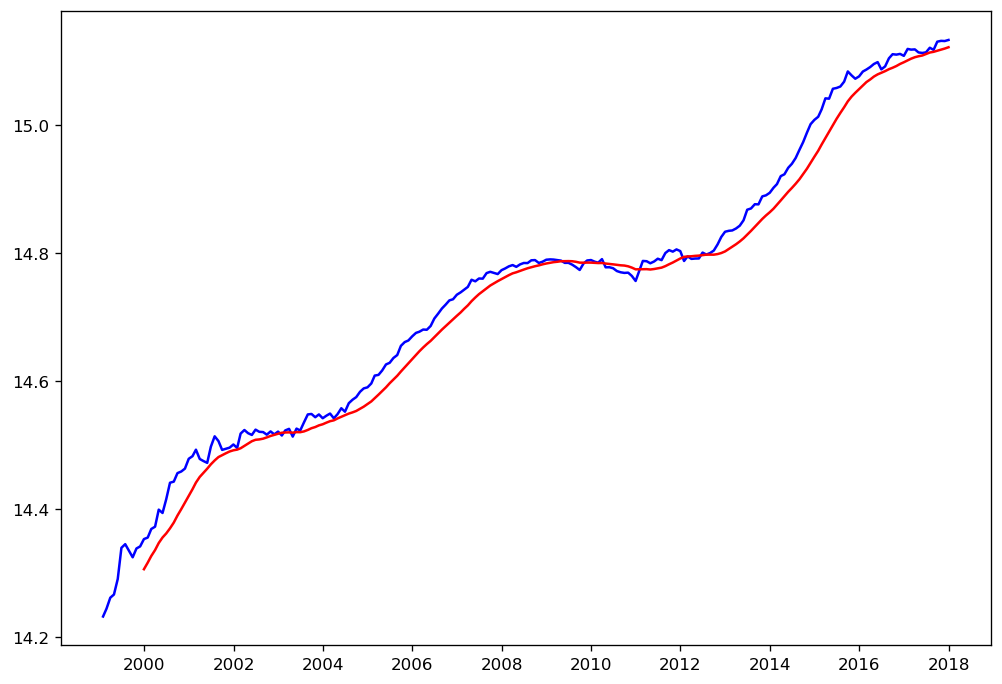

In [33]:
MAVG_df_logscale = df_logscale.rolling(window=12).mean()
MSTD_d_logscale = df_logscale.rolling(window=12).std()

plt.plot(df_logscale, color = 'blue')
plt.plot(MAVG_df_logscale, color = 'red')
plt.show(block=False)

In [34]:
dif_log_MAVlog = df_logscale - MAVG_df_logscale
dif_log_MAVlog.dropna(inplace = True)

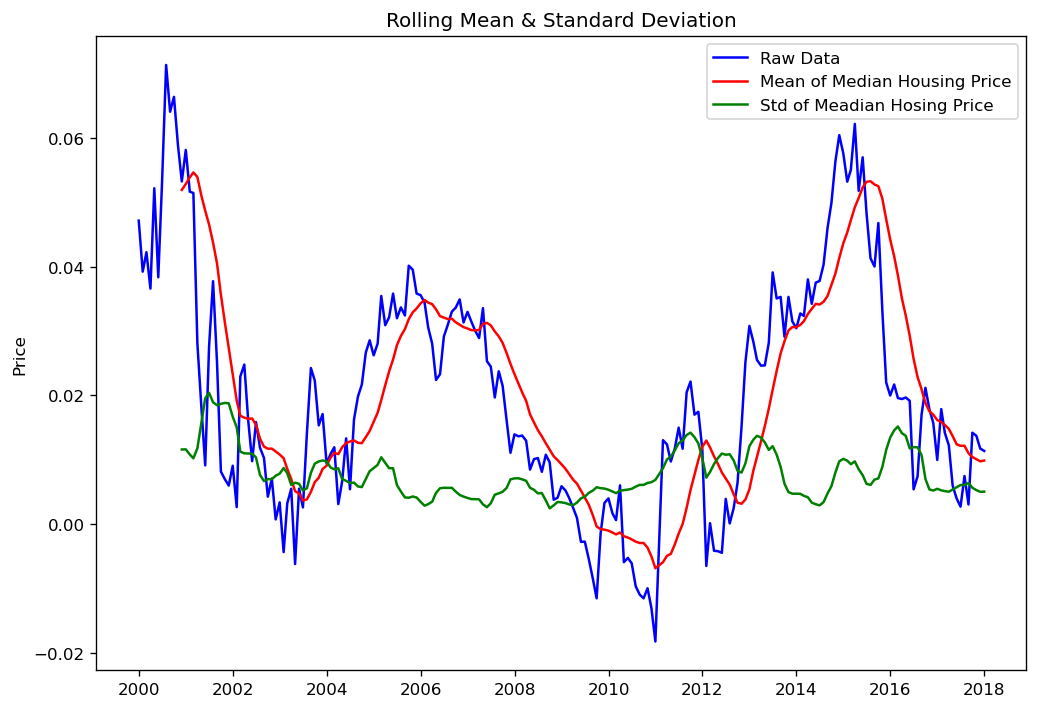

Dickey-Fuller Test:
Test Statistic                  -2.916281
p-value                          0.043487
#Lags Used                       0.000000
Number of Observations Used    215.000000
Critical Values (1%)            -3.461136
Critical Values (5%)            -2.875079
Critical Values (10%)           -2.573986
dtype: float64


In [35]:
stationary_test(dif_log_MAVlog)

### Differencing the data shifting the Log data 

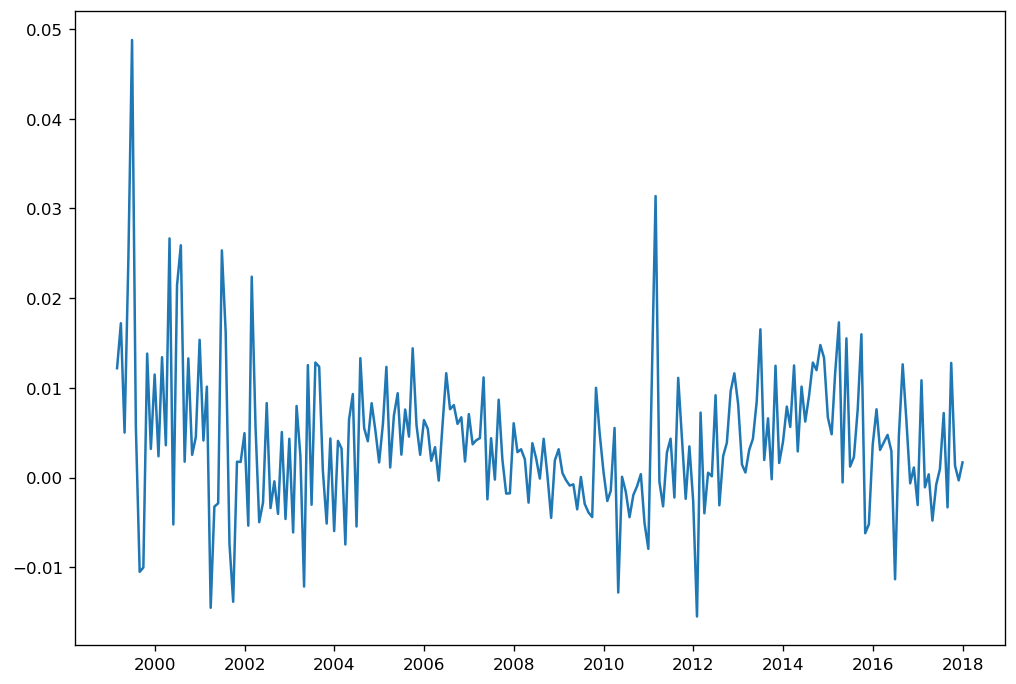

In [36]:
df_logscale_lag = df_logscale - df_logscale.shift()
df_logscale_lag.dropna(inplace=True)
plt.plot(df_logscale_lag)
plt.show(block=False)

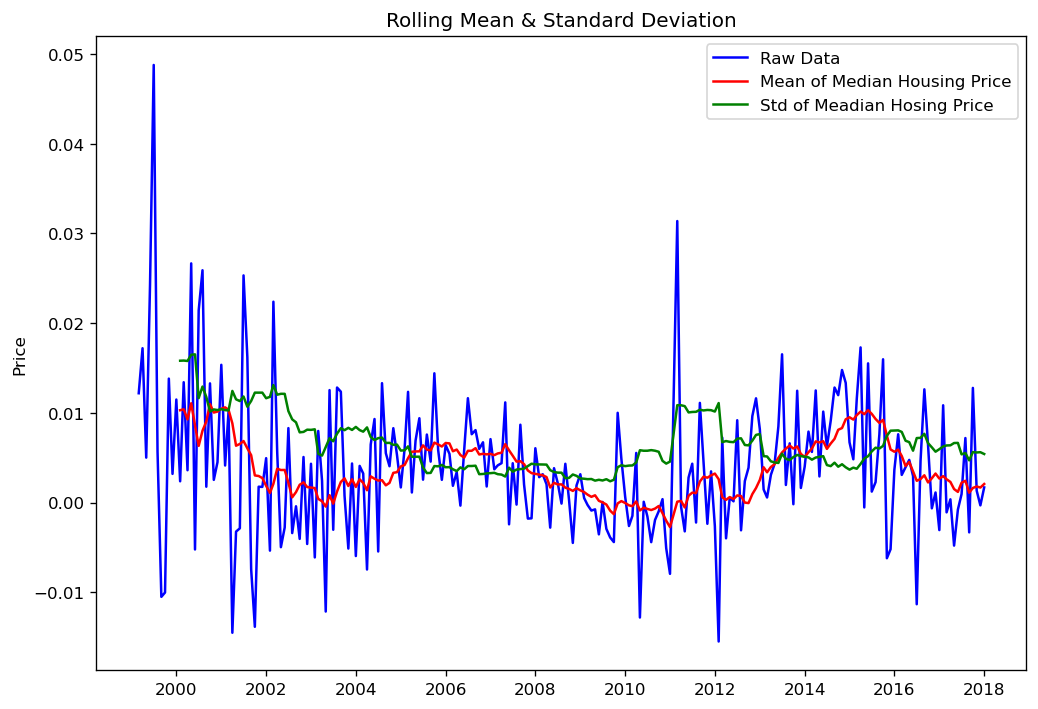

Dickey-Fuller Test:
Test Statistic                  -2.498434
p-value                          0.115856
#Lags Used                      11.000000
Number of Observations Used    214.000000
Critical Values (1%)            -3.461282
Critical Values (5%)            -2.875143
Critical Values (10%)           -2.574020
dtype: float64


In [37]:
stationary_test(df_logscale_lag)

### Using the shifted Log data for ARIMA model

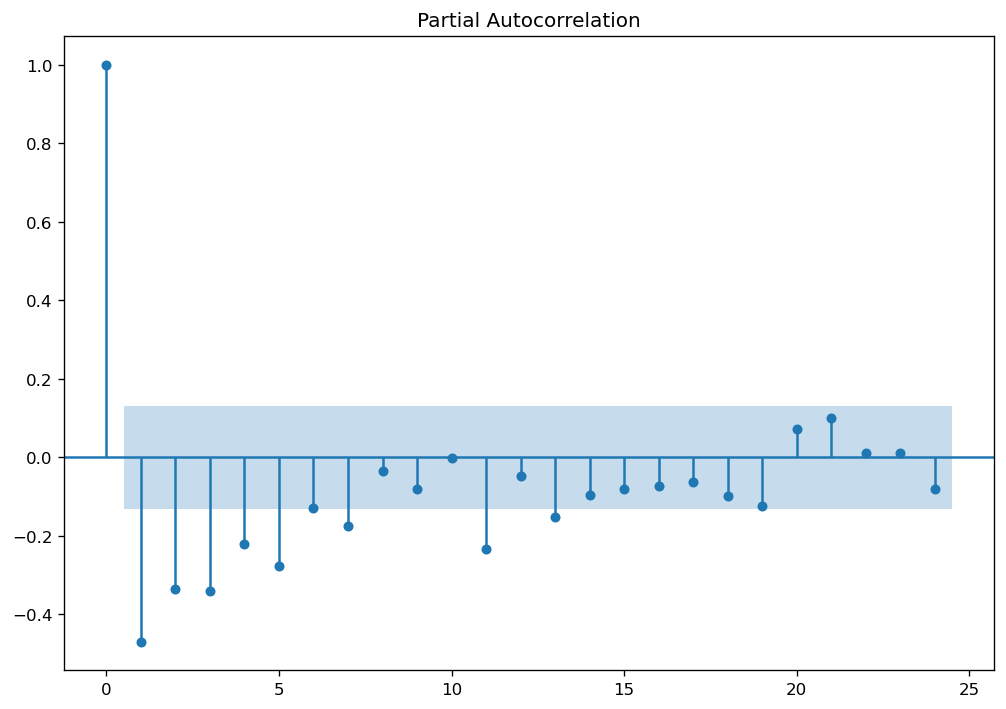

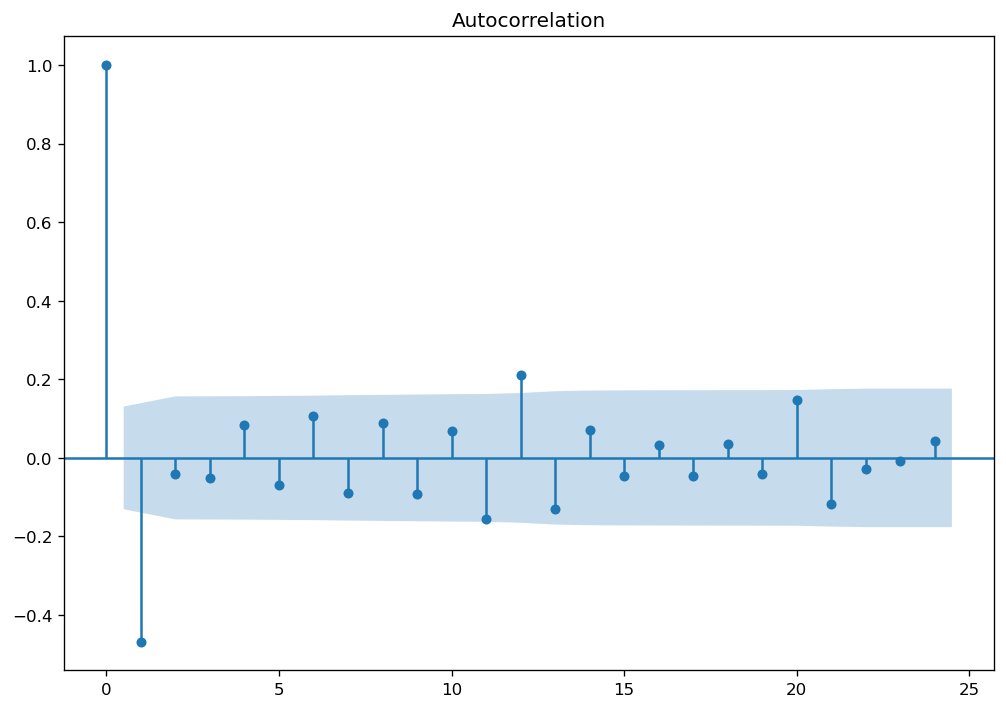

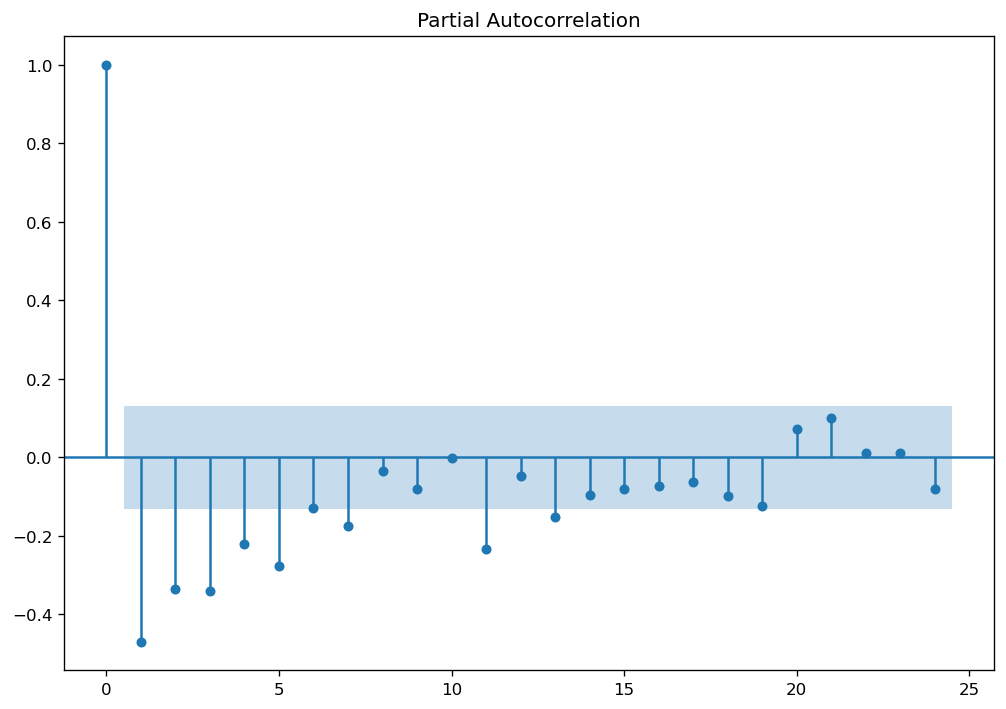

In [38]:
# Find the p and q for the ARIMA model
plot_acf(df_logscale_lag.diff().dropna())
plot_pacf(df_logscale_lag.diff().dropna())

In [39]:
#arma_order_select_ic(df_logscale_lag)

/Users/nolanmercado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nolanmercado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:         D.Mean_Housing   No. Observations:                  226
Model:                 ARIMA(4, 1, 1)   Log Likelihood                 779.895
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sat, 21 May 2022   AIC                          -1545.791
Time:                        11:08:33   BIC                          -1521.847
Sample:                             1   HQIC                         -1536.128
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0045      0.002      2.866      0.004       0.001       0.008
ar.L1.D.Mean_Housing     0.8528      0.097      8.755      0.000       0.662       1.044
ar.L2.D.Mean

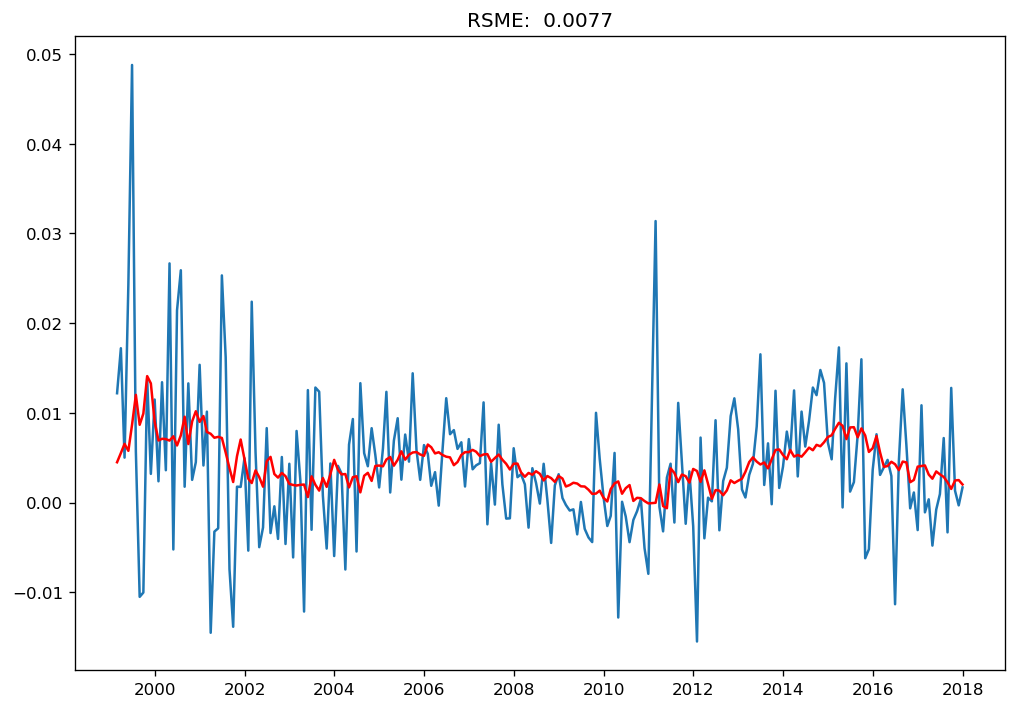

In [40]:
model = ARIMA(df_logscale, order = (4,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(df_logscale_lag)
plt.plot(results_ARIMA.fittedvalues, color ='red')
plt.title('RSME:  %.4f'% np.mean((results_ARIMA.fittedvalues - df_logscale_lag['Mean_Housing'])**2)**0.5)
#plt.show(block=False)

print(results_ARIMA.summary())
print('\n')
print ('Plotting AR Model')

In [41]:
predict_ARIMA_dif = pd.Series(results_ARIMA.fittedvalues, copy = True)
predict_ARIMA_dif_cumsum = predict_ARIMA_dif.cumsum()

In [42]:
predict_ARIMA_log = pd.Series(df_logscale['Mean_Housing'].iloc[0], index = df_logscale.index)
predict_ARIMA_log = predict_ARIMA_log.add(predict_ARIMA_dif_cumsum, fill_value = 0)

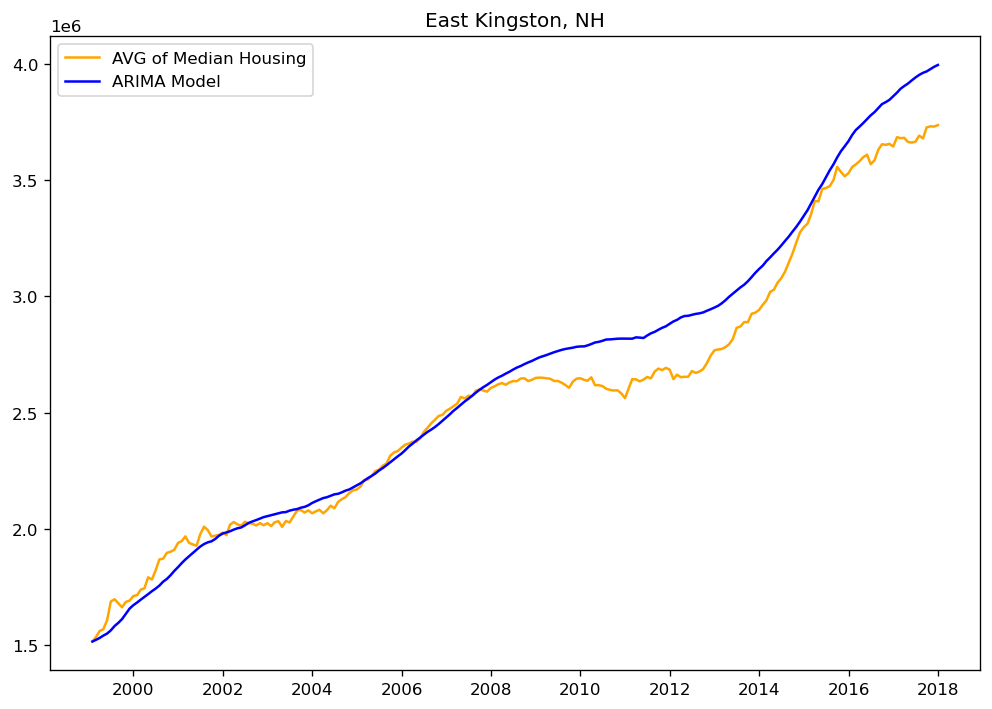

In [43]:
predict_ARIMA = np.exp(predict_ARIMA_log)
predict_ARIMA
plt.title('East Kingston, NH')
plt.plot(train, label = 'AVG of Median Housing', color = 'orange')
plt.plot(predict_ARIMA, label = 'ARIMA Model', color = 'blue')
plt.legend(loc='best')
plt.show(block=False)

In [44]:
# Creating my forcast and acutal values to measure the success of the model
forecast = results_ARIMA.forecast(12)[0]
forecast = np.exp(forecast)

actual = pd.Series(test['Mean_Housing'])

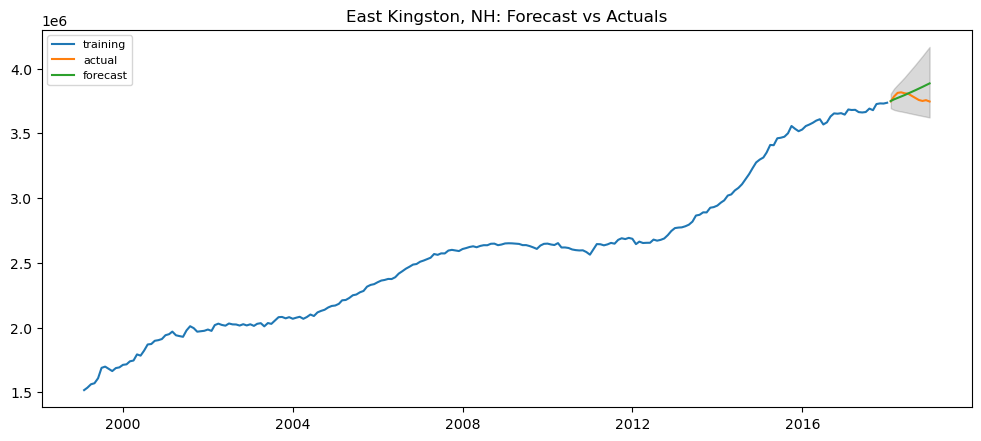

In [45]:
fc, se, conf = results_ARIMA.forecast(12, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(np.exp(conf[:, 0]), index=test.index)
upper_series = pd.Series(np.exp(conf[:, 1]), index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(np.exp(fc_series), label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('East Kingston, NH: Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [46]:
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
mape

0.014511087987472688

In [47]:
rmse = np.mean((forecast - actual)**2)**.5
rmse

70961.67458554803